In [3]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels .stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")

from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [94]:
list_date = pd.date_range("2024-09-01", "2025-05-01", freq='MS',normalize=True)
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                '{date_str}' AS trial_month,
                paid_date,
                t1.user_id AS user_id,
                t1.subscription_id AS subscription_id,
                t2.created_at::date AS created_date,
                t2.first_prolong_date::date AS first_prolong_date,
                t1.reg_source AS reg_source,
                t1.reg_medium AS reg_medium,
                t1.bonus_title AS bonus_title,
                t1.free_days AS free_days,
                b2b_b2c,
                t2.offer_duration,
                payment
                FROM datamarts.finance AS t1
                INNER JOIN (SELECT 
                           user_id,
                           first_prolong_date::date AS first_prolong_date,
                           created_at::date AS created_at,
                           promo_type,
                           offer_duration
                           FROM datamarts.marketing_dash
                           WHERE DATE_TRUNC('month', first_prolong_date)='{date_str}'
                           ) AS t2 
                        ON t1.user_id=t2.user_id
                WHERE paid_date BETWEEN '{date_str}' AND '2025-05-31'
 
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df = pd.concat(result)
df['paid_date'] = df['paid_date'].astype('datetime64[ns]')
df['trial_month'] = df['trial_month'].astype('datetime64[ns]')
df['payment'] = df['payment'].astype('int32')

Время выполнения функции: 0.5715 секунд

Дата '2024-09-01' загружена

Время выполнения функции: 0.5909 секунд

Дата '2024-10-01' загружена

Время выполнения функции: 0.5489 секунд

Дата '2024-11-01' загружена

Время выполнения функции: 0.5499 секунд

Дата '2024-12-01' загружена

Время выполнения функции: 0.6723 секунд

Дата '2025-01-01' загружена

Время выполнения функции: 0.5657 секунд

Дата '2025-02-01' загружена

Время выполнения функции: 0.6351 секунд

Дата '2025-03-01' загружена

Время выполнения функции: 0.5525 секунд

Дата '2025-04-01' загружена

Время выполнения функции: 0.5413 секунд

Дата '2025-05-01' загружена



In [ ]:
# t = df[df['bonus_title'].str.contains('lockto',case=False)].groupby(['bonus_title','reg_medium','reg_source'])['user_id'].nunique().reset_index()
# pivot_table = pd.pivot(data=t,index=['reg_source','reg_medium'],columns='bonus_title',values='user_id').fillna(0)

# pivot_table = pivot_table.astype(int) 
# def highlight_non_zero(val):  
#     # Выделяем все значения, которые не равны нулю  
#     return 'background-color: lightgreen' if val != 0 else ''  

# # Применение стиля к сводной таблице  
# styled_pivot = pivot_table.style.applymap(highlight_non_zero)  

# # Для отображения в Jupyter Notebook  
# styled_pivot

In [ ]:
# Flocktory оставляем только
# df = df[df['bonus_title'].str.contains('lockto',case=False)]
# df['bonus_title2'] = df['bonus_title'].str.split(' ', expand=True)[1]
# df = df[df['bonus_title2'].isin(['BSP','Exchange'])]

In [ ]:
# query = f'''            SELECT
#                         date_trunc('month',created_at::date) AS trial_month,
#                         free_days,
#                         reg_source,
#                         reg_medium,
#                         first_prolong_date,
#                         bonus_title,
#                         user_id
#                         FROM datamarts.marketing_dash
#                         WHERE bonus_title like '%lockto%'
#                         AND created_at BETWEEN '2023-12-01' AND '2025-01-01'
#             '''
# df_flocktory = execute(query,user = 'kmekhtiev')   
# df_flocktory['trial_month'] = df_flocktory['trial_month'].astype('datetime64[ns]')

In [ ]:
# df_flocktory = df_flocktory[df_flocktory['bonus_title'].str.contains('lockto',case=False)]
# df_flocktory['bonus_title2'] = df_flocktory['bonus_title'].str.split(' ', expand=True)[1]
# df_flocktory = df_flocktory[df_flocktory['bonus_title2'].isin(['BSP','Exchange'])]

In [ ]:
# df_flocktory['cac'] = df_flocktory.apply(lambda t: 375 if t.trial_month<pd.Timestamp('2024-09-01') else (415 if t.trial_month>=pd.Timestamp('2024-09-01') and t.bonus_title=='exhcnage' else 375),axis=1)

# df_flocktory['cnt_user'] = df_flocktory.groupby(['trial_month','bonus_title2'])['user_id'].transform('count')

# df_flocktory['cnt_paid_user'] = df_flocktory[df_flocktory['first_prolong_date']!='1970-01-01'].groupby(['trial_month','bonus_title2'])['user_id'].transform('count')
# df_flocktory['cnt_paid_user'] = df_flocktory['cnt_paid_user'].fillna(0)
# df_flocktory['cnt_paid_user'] = df_flocktory['cnt_paid_user'].astype('int32')

# df_flocktory

In [ ]:
# df_flocktory['cac'] = df_flocktory.apply(lambda t: 375 if t.trial_month<pd.Timestamp('2024-09-01') else (415 if t.trial_month>=pd.Timestamp('2024-09-01') and t.bonus_title=='exhcnage' else 375),axis=1)

# df_flocktory['cnt_user'] = df_flocktory.groupby(['trial_month','bonus_title2'])['user_id'].transform('count')

# df_flocktory['cnt_paid_user'] = df_flocktory[df_flocktory['first_prolong_date']!='1970-01-01'].groupby(['trial_month','bonus_title2'])['user_id'].transform('count')
# df_flocktory['cnt_paid_user'] = df_flocktory['cnt_paid_user'].fillna(0)
# df_flocktory['cnt_paid_user'] = df_flocktory['cnt_paid_user'].astype('int32')

# df_flocktory['total_cost'] = df_flocktory['cac'] * df_flocktory['cnt_user']
# df_flocktory['cac_paid_user'] = df_flocktory.apply(lambda x : x.total_cost//x.cnt_paid_user if x.cnt_paid_user>0 else x.total_cost,axis=1)
# #df_flocktory.groupby(['trial_month','reg_source','reg_medium'])[['cnt_user','cnt_paid_user','total_cost']].max().reset_index().sort_values(by='trial_month')

In [ ]:
# df_flocktory.groupby(['trial_month','bonus_title'])[['cnt_user','cnt_paid_user']].mean()

In [ ]:
# df_merge = pd.merge(df[(df['trial_month']!='2024-09-01')],df_flocktory[['user_id','cac_paid_user']],how='left',on=['user_id'])

In [ ]:
# df_flocktory[(df_flocktory['first_prolong_date']!='1970-01-01')].groupby('trial_month')['cac_paid_user'].sum()/df_flocktory[(df_flocktory['first_prolong_date']!='1970-01-01')].groupby('trial_month')['user_id'].count()

In [101]:
df

,trial_month,paid_date,user_id,subscription_id,created_date,first_prolong_date,reg_source,reg_medium,bonus_title,free_days,b2b_b2c,offer_duration,payment,paid_month
0,2024-09-01,2025-02-18,d62a0c16-3623-4a68-8e38-38f5441d09f2,8022d51f-b830-4137-8fc2-80b7b3466040,2024-08-14,2024-09-18,none,none,Flocktory Exchange 2,35,b2c,1 month,299,2025-02
1,2024-09-01,2025-02-18,fa9d049d-7cf9-43eb-9c34-66384d0ad773,a9c53aed-5d21-4fc6-8b60-ee3b005079c0,2024-08-14,2024-09-18,none,none,Flocktory Exchange 2,35,b2c,1 month,299,2025-02
2,2024-09-01,2025-02-18,78e56dd2-2d81-4218-863c-9c73fdb43fb5,21ac9990-b12d-4bb5-a2ae-5ca97f8e99fc,2024-09-18,2024-09-18,none,none,,14,b2c,1 month,299,2025-02
3,2024-09-01,2025-02-18,60b9c591-345e-4ff8-949d-6734862340f1,fd8f71bf-c852-4879-8e75-b2fb268224e4,2024-08-14,2024-09-18,none,none,Flocktory Exchange 2,35,b2c,1 month,299,2025-02
4,2024-09-01,2025-02-18,219da1c5-005a-4095-8186-9f03464e9365,e1f55f70-078a-43e9-bf49-6689b5ae8548,2024-09-04,2024-09-18,none,none,,14,b2c,1 month,299,2025-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,2025-05-01,2025-05-31,ae4e73de-a054-43d9-9bc6-72101d7d1533,f1a4e805-6adf-4c18-8f33-90093fce332d,2025-04-27,2025-05-31,flocktory,exchange,Flocktory: Exchange 365 (3&399) ver 2 (act),35,b2c,3 month,399,2025-05
3127,2025-05-01,2025-05-31,1a85d2db-5a29-4f6c-a56a-2485322c077f,cba3fe11-6e6f-4186-a22a-36af7693b22c,2025-05-29,2025-05-31,none,none,,3,b2c,3 month,649,2025-05
3128,2025-05-01,2025-05-31,efd69072-1ba1-4e35-b966-b387545e7636,5447f7ab-4cbe-4fcf-8b6c-dfc3256549d0,2025-05-31,2025-05-31,none,none,Flocktory: Exchange. 29 руб/месяц - act,37,b2c,1 month,29,2025-05
3129,2025-05-01,2025-05-31,8f4c6559-7248-4726-a81d-f83038703179,a548818b-127c-4f1e-bbab-e9dffc654679,2025-05-29,2025-05-31,none,none,,3,b2c,12 month,1550,2025-05


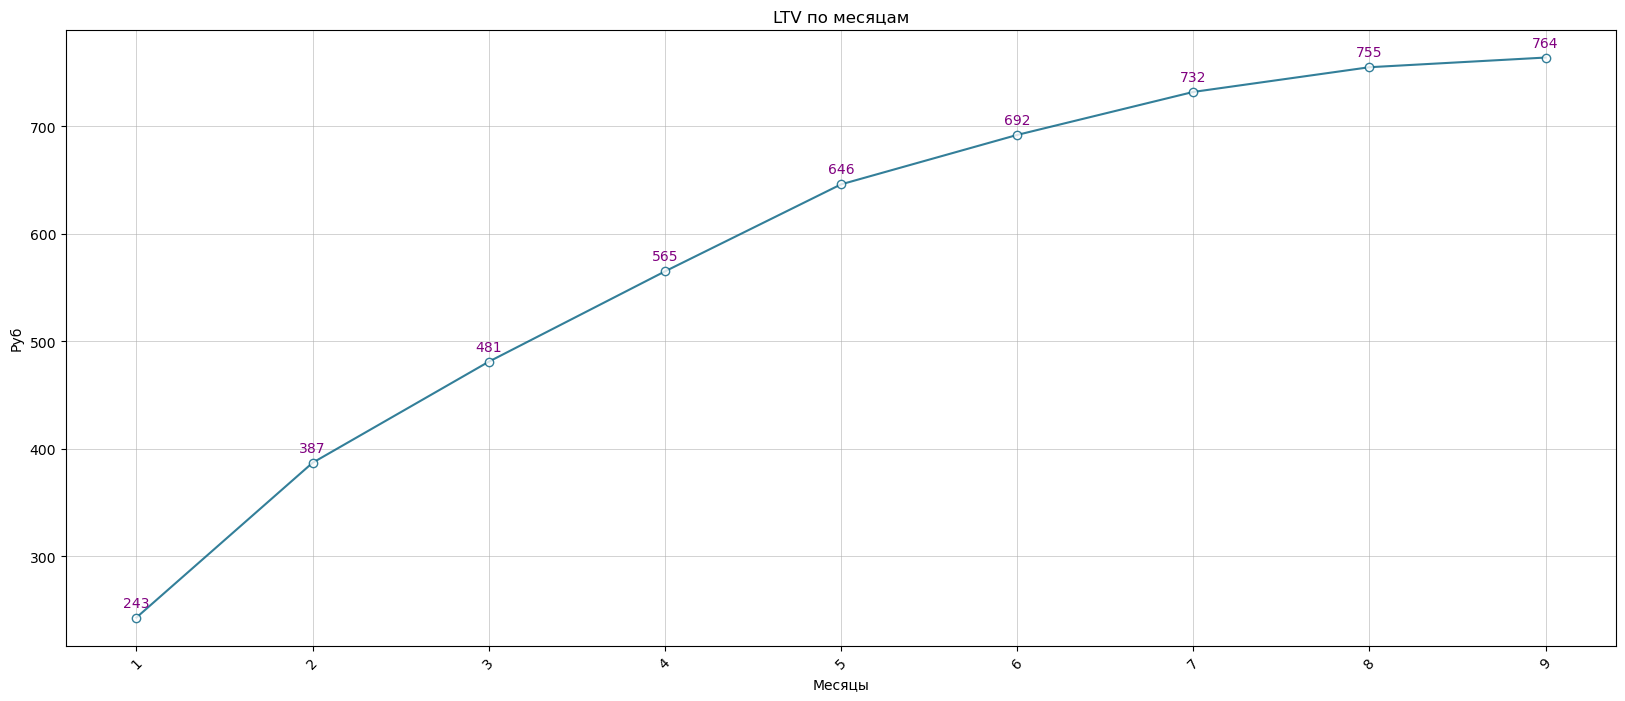

In [103]:
df['paid_month'] = df['paid_date'].dt.to_period('M')

df_agg = df[df['offer_duration']=='1 month'].groupby(['trial_month','paid_month']).agg({'payment':'sum','user_id':'count'}).reset_index()

# Расчет кумулятивной суммы, и добавления поля по числу пользователей когорты 
df_agg['cumulative'] = df_agg.groupby('trial_month')['payment'].cumsum()
df_agg['uniq_user'] = df_agg.groupby('trial_month')['user_id'].transform('max')

#Расчет ltv
df_agg['ltv'] = df_agg.cumulative/df_agg.uniq_user

# Нумерация месяцев
df_agg['num_of_month'] = df_agg.groupby('trial_month')['paid_month'].rank(method='first').astype('int')
df_agg = df_agg[df_agg['num_of_month']<10] # Ограничиваем 6-ью месяцами

# Сделаем pivot 
df_pivot = pd.pivot(data = df_agg,index = 'trial_month',columns = 'num_of_month',values = 'ltv')
df_pivot['uniq_user'] = df_agg.groupby('trial_month')['uniq_user'].max()

# Создаем DataFrame с данными для расчета средневзвешенного LTV
weighted_ltv = df_agg.pivot(index='trial_month', columns='num_of_month', values='ltv')
user_counts = df_agg.pivot(index='trial_month', columns='num_of_month', values='uniq_user')

# Рассчитываем средневзвешенное значение LTV для каждого 'num_of_month'
weighted_avg_ltv = ((weighted_ltv * user_counts).sum() / user_counts.sum()).round().astype('int')


weighted_avg_ltv = weighted_avg_ltv.reset_index()
weighted_avg_ltv = weighted_avg_ltv.rename(columns={0:'cumsum'})

# Построение графика месячного LTV
plt.figure(figsize=(20,8))
plt.plot(weighted_avg_ltv['num_of_month'], weighted_avg_ltv['cumsum'], marker='o', linestyle='-', color='#005f80',markerfacecolor='white',alpha=0.8)

for i in range(len(weighted_avg_ltv['num_of_month'])):  
    plt.text(weighted_avg_ltv['num_of_month'][i], weighted_avg_ltv['cumsum'][i]+10,
             str(weighted_avg_ltv['cumsum'][i]),
             ha='center', fontsize=10,color='purple')  
plt.xlabel('Месяцы')
plt.ylabel('Руб')
plt.title('LTV по месяцам')
plt.grid(True,linewidth=0.4)
plt.xticks(rotation=45)
plt.show()

In [75]:
list_date = pd.date_range("2024-12-01", "2025-05-01", freq='MS',normalize=True)
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                '{date_str}' AS trial_month,
                paid_date,
                t1.user_id AS user_id,
                t1.subscription_id AS subscription_id,
                t2.created_at::date AS created_date,
                t2.first_prolong_date::date AS first_prolong_date,
                t1.reg_source AS reg_source,
                t1.reg_medium AS reg_medium,
                t1.bonus_title AS bonus_title,
                t1.free_days AS free_days,
                b2b_b2c,
                t2.offer_duration,
                payment
                FROM datamarts.finance AS t1
                INNER JOIN (SELECT 
                           user_id,
                           first_prolong_date::date AS first_prolong_date,
                           created_at::date AS created_at,
                           promo_type,
                           offer_duration
                           FROM datamarts.marketing_dash
                           WHERE DATE_TRUNC('month', first_prolong_date)='{date_str}'
                           ) AS t2 
                        ON t1.user_id=t2.user_id
                WHERE paid_date BETWEEN '{date_str}' AND '2025-05-31'
 
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df = pd.concat(result)
df['paid_date'] = df['paid_date'].astype('datetime64[ns]')
df['trial_month'] = df['trial_month'].astype('datetime64[ns]')
df['payment'] = df['payment'].astype('int32')

Время выполнения функции: 0.8324 секунд

Дата '2024-12-01' загружена

Время выполнения функции: 1.0258 секунд

Дата '2025-01-01' загружена

Время выполнения функции: 1.1108 секунд

Дата '2025-02-01' загружена

Время выполнения функции: 1.0035 секунд

Дата '2025-03-01' загружена

Время выполнения функции: 0.7771 секунд

Дата '2025-04-01' загружена

Время выполнения функции: 0.819 секунд

Дата '2025-05-01' загружена



In [ ]:
df['paid_month'] = df['paid_date'].dt.to_period('M')
df_agg = df.groupby(['trial_month','paid_month']).agg({'payment':'sum','user_id':'count','cac_paid_user':'sum'}).reset_index()

# Расчет кумулятивной суммы, и добавления поля по числу пользователей когорты 
df_agg['cumulative'] = df_agg.groupby('trial_month')['payment'].cumsum()
df_agg['uniq_user'] = df_agg.groupby('trial_month')['user_id'].transform('max')
df_agg['cac_cohort'] = df_agg.groupby('trial_month')['cac_paid_user'].transform('max')

#Расчет ltv
df_agg['ltv'] = df_agg.cumulative/df_agg.uniq_user

# Нумерация месяцев
df_agg['num_of_month'] = df_agg.groupby('trial_month')['paid_month'].rank(method='first').astype('int')
df_agg = df_agg[df_agg['num_of_month']<7] # Ограничиваем 6-ью месяцами

# Сделаем pivot 
df_pivot = pd.pivot(data = df_agg,index = 'trial_month',columns = 'num_of_month',values = 'ltv')
df_pivot['uniq_user'] = df_agg.groupby('trial_month')['uniq_user'].max()

# Создаем DataFrame с данными для расчета средневзвешенного LTV
weighted_ltv = df_agg.pivot(index='trial_month', columns='num_of_month', values='ltv')
user_counts = df_agg.pivot(index='trial_month', columns='num_of_month', values='uniq_user')

# Рассчитываем средневзвешенное значение LTV для каждого 'num_of_month'
weighted_avg_ltv = ((weighted_ltv * user_counts).sum() / user_counts.sum()).round().astype('int')


weighted_avg_ltv = weighted_avg_ltv.reset_index()
weighted_avg_ltv = weighted_avg_ltv.rename(columns={0:'cumsum'})

# Построение графика месячного LTV
plt.figure(figsize=(20,8))
plt.plot(weighted_avg_ltv['num_of_month'], weighted_avg_ltv['cumsum'], marker='o', linestyle='-', color='#005f80',markerfacecolor='white',alpha=0.8)

for i in range(len(weighted_avg_ltv['num_of_month'])):  
    plt.text(weighted_avg_ltv['num_of_month'][i], weighted_avg_ltv['cumsum'][i]+10,
             str(weighted_avg_ltv['cumsum'][i]),
             ha='center', fontsize=10,color='purple')  
plt.xlabel('Месяцы')
plt.ylabel('Руб')
plt.title('Кумулятивная сумма на пользователя по месяцам (Flocktory)')
plt.grid(True,linewidth=0.4)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Расчет кумулятивной суммы, и добавления поля по числу пользователей когорты 
df_agg['cumulative'] = df_agg.groupby('trial_month')['payment'].cumsum()
df_agg['uniq_user'] = df_agg.groupby('trial_month')['user_id'].transform('max')
df_agg['cac_cohort'] = df_agg.groupby('trial_month')['cac_paid_user'].transform('max')

#Расчет ltv
df_agg['ltv'] = df_agg.cumulative/df_agg.uniq_user

In [ ]:
df_agg

In [ ]:
weighted_avg_ltv

In [ ]:
df_merge['paid_month'] = df_merge['paid_date'].dt.to_period('M')
df_agg = df_merge.groupby(['trial_month','paid_month']).agg({'payment':'sum','user_id':'count','cac_paid_user':'sum'}).reset_index()

# Расчет кумулятивной суммы и добавления поля по числу пользователей когорты 
df_agg['cumulative'] = df_agg.groupby('trial_month')['payment'].cumsum()
df_agg['uniq_user'] = df_agg.groupby('trial_month')['user_id'].transform('max')
df_agg['cac_cohort'] = df_agg.groupby('trial_month')['cac_paid_user'].transform('max')

#Расчет ltv
df_agg['ltv'] = (df_agg['cumulative'] - df_agg['cac_cohort']) / df_agg['uniq_user']

# Нумерация месяцев
df_agg['num_of_month'] = df_agg.groupby('trial_month')['paid_month'].rank(method='first').astype('int')
df_agg = df_agg[df_agg['num_of_month']<7] # Ограничиваем 6-ью месяцами

# Сделаем pivot 
df_pivot = pd.pivot(data = df_agg,index = 'trial_month',columns = 'num_of_month',values = 'ltv')
df_pivot['uniq_user'] = df_agg.groupby('trial_month')['uniq_user'].max()

# Создаем DataFrame с данными для расчета средневзвешенного LTV
weighted_ltv = df_agg.pivot(index='trial_month', columns='num_of_month', values='ltv')
user_counts = df_agg.pivot(index='trial_month', columns='num_of_month', values='uniq_user')

# Рассчитываем средневзвешенное значение LTV для каждого 'num_of_month'
weighted_avg_ltv = ((weighted_ltv * user_counts).sum() / user_counts.sum()).round().astype('int')


weighted_avg_ltv = weighted_avg_ltv.reset_index()
weighted_avg_ltv = weighted_avg_ltv.rename(columns={0:'ltv'})
# weighted_avg_ltv['ltv']=weighted_avg_ltv['cumsum'] - weighted_avg_ltv['cac']

# Построение графика месячного LTV
plt.figure(figsize=(20,8))
plt.plot(weighted_avg_ltv['num_of_month'], weighted_avg_ltv['ltv'], marker='o', linestyle='-', color='#005f80',markerfacecolor='white',alpha=0.8)
for i in range(len(weighted_avg_ltv['num_of_month'])):
    plt.text(weighted_avg_ltv['num_of_month'][i], weighted_avg_ltv['ltv'][i]+10,
             str(weighted_avg_ltv['ltv'][i]),
             ha='center', fontsize=10,color='purple')  
plt.xlabel('Месяцы')
plt.ylabel('Руб')
plt.title('Изменение LTV по месяцам (Flocktory)')
plt.grid(True,linewidth=0.4)
plt.xticks(rotation=45)
plt.show()

In [ ]:
weighted_ltv

In [ ]:
user_counts

In [ ]:
weighted_avg_ltv

In [ ]:
df_agg['cumsum'] = (df_agg['cumulative']) / df_agg['uniq_user']
df_agg

In [ ]:
pd.pivot(data=df_agg,index='num_of_month',columns='trial_month',values='ltv')

# Помесячная выручка

In [ ]:
list_date = pd.date_range("2024-01-01", "2024-08-01", freq='MS',normalize=True)
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                '{date_str}' AS date_month,
                paid_at::date AS paid_date,
                s.user_id AS user_id,
                i.subscription_id AS subscription_id,
                s.created_at::date AS created_date,
                sum(i.price_cents)/100 AS payment
                FROM  product_x.invoices i
                LEFT JOIN product_x.subscriptions s
                ON s.id = i.subscription_id
                LEFT JOIN product_x.users u 
                ON u.id = s.user_id
                WHERE u.user_type = 'regular'
                      AND u.vipplay = FALSE
                      AND s.state in ('normal_period','trial','canceled','grace_period')
                      AND DATE_TRUNC('month', paid_at::date)='{date_str}'
                      AND i.state in ('success')
                      AND i.price_cents > 100
                      AND i.price_currency = 'RUB'
                GROUP BY 1,2,3,4,5
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df = pd.concat(result)
df['paid_date'] = df['paid_date'].astype('datetime64[ns]')
df['payment'] = df['payment'].astype('int32')

In [ ]:
df.groupby(['date_month'])['paid_date'].nunique().reset_index()

In [ ]:
df.groupby('date_month').agg({'payment':'sum','subscription_id':'nunique'}).reset_index()

# Выручка за 6 месяцев 

In [ ]:
list_date = pd.date_range("2024-07-01", "2024-08-01", freq='D')
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                '{date_str}' AS date,
                paid_at::date AS paid_date,
                s.user_id AS user_id,
                i.subscription_id AS subscription_id,
                s.created_at::date AS created_date,
                sum(i.price_cents)/100 AS payment
                FROM  product_x.invoices i
                LEFT JOIN product_x.subscriptions s
                ON s.id = i.subscription_id
                LEFT JOIN product_x.users u 
                ON u.id = s.user_id
                WHERE u.user_type = 'regular'
                      AND u.vipplay = FALSE
                      AND s.state in ('normal_period','trial','canceled','grace_period')
                      AND paid_date BETWEEN '{date}'::date - INTERVAL '179' DAY and '{date}'::date
                      AND i.state in ('success','refunded')
                      AND i.price_cents > 100
                      AND i.price_currency = 'RUB'
                GROUP BY 1,2,3,4,5
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df = pd.concat(result)
df['paid_date'] = df['paid_date'].astype('datetime64[ns]')
df['payment'] = df['payment'].astype('int32')

In [ ]:
df.groupby(['date'])['paid_date'].nunique().reset_index()

In [ ]:
df.groupby('date').agg({'payment':'sum','subscription_id':'nunique'}).reset_index()

# Выручка помесячно и число посетителей помесячно 

In [ ]:
list_date = pd.date_range("2024-06-30", "2024-07-30", freq='D')
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                '{date_str}' AS date_month,
                paid_at::date AS paid_date,
                s.user_id AS user_id,
                i.subscription_id AS subscription_id,
                s.created_at::date AS created_date,
                sum(i.price_cents)/100 AS payment
                FROM  product_x.invoices i
                LEFT JOIN product_x.subscriptions s
                ON s.id = i.subscription_id
                LEFT JOIN product_x.users u 
                ON u.id = s.user_id
                WHERE u.user_type = 'regular'
                      AND u.vipplay = FALSE
                      --AND s.state in ('normal_period','trial','canceled','grace_period')
                      AND state in ('trial')
                      AND i.deleted_at is null
                      AND paid_date BETWEEN '{date}'::date - INTERVAL '29' DAY and '{date}'::date
                      AND i.state in ('success')
                      AND i.price_cents > 100
                      AND i.price_currency = 'RUB'
                GROUP BY 1,2,3,4,5
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df_revenue = pd.concat(result)
df_revenue['paid_date'] = df_revenue['paid_date'].astype('datetime64[ns]')
df_revenue['date_month'] = df_revenue['date_month'].astype('datetime64[ns]')
df_revenue['payment'] = df_revenue['payment'].astype('int32')

In [ ]:
df_revenue

In [ ]:
list_date = pd.date_range("2024-06-30", "2024-07-29", freq='D')
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                '{date_str}' AS date_month,
                paid_at::date AS paid_date,
                s.user_id AS user_id,
                i.subscription_id AS subscription_id,
                s.created_at::date AS created_date,
                i.price_cents/100 AS payment,
                count(s.user_id) OVER (partition by s.user_id,'{date_str}') as cnt_profile
                FROM  product_x.invoices i
                LEFT JOIN product_x.subscriptions s
                ON s.id = i.subscription_id
                LEFT JOIN product_x.users u 
                ON u.id = s.user_id
                WHERE u.user_type = 'regular'
                      AND u.vipplay = FALSE
                      AND s.state in ('normal_period','trial','canceled','grace_period')
                      AND paid_date BETWEEN '{date}'::date - INTERVAL '29' DAY and '{date}'::date
                      AND i.state in ('success')
                      AND i.price_cents > 100
                      AND i.price_currency = 'RUB'
                      AND (u.email NOT LIKE '%@test%' OR u.email IS NULL)
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df_revenue2 = pd.concat(result)
df_revenue2['paid_date'] = df_revenue2['paid_date'].astype('datetime64[ns]')
df_revenue2['date_month'] = df_revenue2['date_month'].astype('datetime64[ns]')
df_revenue2['payment'] = df_revenue2['payment'].astype('int32')

In [ ]:
list_date = pd.date_range("2024-06-30", "2024-07-30", freq='D')
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
            date_month,
            COUNT(DISTINCT visitor_id) AS cnt_visitor
            FROM
                (SELECT
                '{date_str}' AS date_month,
                date,
                visitor_id
                FROM
                datamarts.sandbox_data_distr
                WHERE client_type!='backend' 
                AND date BETWEEN '{date}'::date - interval '29' DAY AND '{date}'::date
                GROUP BY 1,2,3
                )
            GROUP BY 1
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df_visitor = pd.concat(result)
df_visitor['date_month'] = df_visitor['date_month'].astype('datetime64[ns]')

In [ ]:
list_date = pd.date_range("2024-01-01", "2024-08-01", freq='MS',normalize=True)
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
    SELECT 
            date_month,
            COUNT(DISTINCT visitor_id) AS cnt_visitor
            FROM
                (SELECT
                '{date_str}' AS date_month,
                date,
                visitor_id
                FROM
                datamarts.sandbox_data_distr
                WHERE client_type!='backend' 
                AND DATE_TRUNC('month', date::date)='{date_str}'
                GROUP BY 1,2,3
                )
            GROUP BY 1
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df_visitor2 = pd.concat(result)
df_visitor2['date_month'] = df_visitor2['date_month'].astype('datetime64[ns]')

In [ ]:
df_visitor

In [ ]:
df_visitor2

In [ ]:
df_revenue.groupby(['date_month'])['paid_date'].nunique().reset_index()

In [ ]:
df_revenue_agg = df_revenue.groupby('date_month').agg({'payment':'sum','subscription_id':'nunique'}).reset_index()
df_revenue_agg['ARPPU'] = df_revenue_agg.payment / df_revenue_agg.subscription_id
df_revenue_agg[df_revenue_agg.date_month>='2024-07-25']

In [ ]:
df_revenue_agg = df_revenue2.groupby('date_month').agg({'payment':'sum','subscription_id':'nunique','user_id':'nunique'}).reset_index()
df_revenue_agg['ARPPU'] = df_revenue_agg.payment / df_revenue_agg.subscription_id
df_revenue_agg[df_revenue_agg.date_month>='2024-07-25']

In [ ]:
df_revenue_agg = df_revenue2[df_revenue2.cnt_profile==1].groupby('date_month').agg({'payment':'sum','subscription_id':'nunique','user_id':'nunique'}).reset_index()
df_revenue_agg['ARPPU'] = df_revenue_agg.payment / df_revenue_agg.subscription_id
df_revenue_agg[df_revenue_agg.date_month>='2024-07-25']

In [ ]:
dt = (df_revenue2[df_revenue2.date_month=='2024-07-27']
        .groupby('user_id')['user_id']
        .size()
        .reset_index(name='count')
     )
dt[dt['count']>1]

In [ ]:
df_revenue_agg = df_revenue.groupby('date_month').agg({'payment':'sum','subscription_id':'nunique','subscription_id':'count'}).reset_index()
df_revenue_agg['ARPPU'] = df_revenue_agg.payment / df_revenue_agg.subscription_id
df_revenue_agg

In [ ]:
df_revenue_agg = df_revenue.groupby('date_month').agg({'payment':'sum','subscription_id':'count'}).reset_index()
df_revenue_agg

In [ ]:
df_revenue_agg2 = pd.merge(df_revenue_agg,df_visitor,how='left',on='date_month')[['date_month','payment','subscription_id','cnt_visitor','ARPPU']]
df_revenue_agg2['ARPU'] = df_revenue_agg2['payment'] / df_revenue_agg2['cnt_visitor']
df_revenue_agg2

In [ ]:
list_date = pd.date_range("2024-06-30", "2024-07-30", freq='D')
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                    '{date}' AS date,
                     profile_id,
                     user_id,
                     first_prolong_date::date AS first_prolong_date,
                     ends_at,
                     ends_at - first_prolong_date AS lt
                     FROM datamarts.marketing_dash_distr
                     WHERE first_prolong_date BETWEEN '{date}'::date - interval '179' DAY AND '{date}'::date
                     AND payer=1 
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df_lt = pd.concat(result)
df_lt['date'] = df_lt['date'].astype('datetime64[ns]')

In [ ]:
def sum_of_digits(N):
    sum_digits = 0
    while N > 0:
        sum_digits += N % 10
        N //= 10
    return sum_digits

# Пример использования:
N = -3
print(sum_of_digits(N))  # Вывод: 6

In [ ]:
sum_digits = 0
N= -123
sum_digits += N % 10
N //= 10
print(sum_digits)
print(N)

In [ ]:
-123 % 10